In [1]:
from __future__ import division

import datautils
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import math
import models

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [12]:
# Read in the data
num_classes = 250 #250
res = 128

tic = time.clock()
set1, set2, set3, labels = datautils.get_cross_val_data(num_classes=num_classes, res=128, flip=True)
X_train1, y_train1, X_test1, y_test1 = set1
X_train2, y_train2, X_test2, y_test2 = set2
X_train3, y_train3, X_test3, y_test3 = set3
toc = time.clock()
print ("Read {} images in {:5g} seconds".format(X_test1.shape[0] + X_test2.shape[0] + X_test3.shape[0], toc - tic))
print ("X_train1: ", X_train1.shape)
print ("y_train1: ", y_train1.shape)
print ("X_test1: ", X_test1.shape)
print ("y_test1: ", y_test1.shape)

print ("X_train2: ", X_train2.shape)
print ("y_train2: ", y_train2.shape)
print ("X_test2: ", X_test2.shape)
print ("y_test2: ", y_test2.shape)

print ("X_train3: ", X_train3.shape)
print ("y_train3: ", y_train3.shape)
print ("X_test3: ", X_test3.shape)
print ("y_test3: ", y_test3.shape)

Read 20000 images in 9.37968 seconds
X_train1:  (27000, 128, 128, 1)
y_train1:  (27000,)
X_test1:  (6500, 128, 128, 1)
y_test1:  (6500,)
X_train2:  (26500, 128, 128, 1)
y_train2:  (26500,)
X_test2:  (6750, 128, 128, 1)
y_test2:  (6750,)
X_train3:  (26500, 128, 128, 1)
y_train3:  (26500,)
X_test3:  (6750, 128, 128, 1)
y_test3:  (6750,)


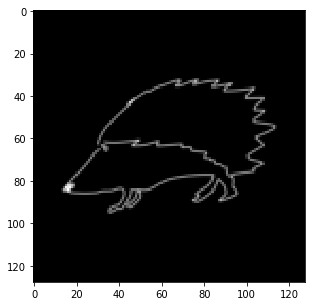

hedgehog


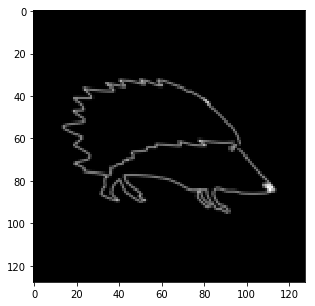

hedgehog


In [16]:
sample = np.random.randint(13500)
plt.imshow(X_train1[sample].reshape(128, 128))
plt.show()
print (labels[y_train1[sample]])
plt.imshow(X_train1[sample+13500].reshape(128, 128))
plt.show()
print (labels[y_train1[sample+13500]])

In [5]:
tf.reset_default_graph()

reg_val = 1e0
learning_rate = 1e-3
dr = 0.5

X = tf.placeholder(tf.float32, [None, res, res, 1])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
lr = tf.placeholder(tf.float32)
reg = tf.placeholder(tf.float32)
dropout_rate = tf.placeholder(tf.float32)

y_out = models.resnet_wide(X, y, 
                           layer_depth=3, 
                           num_classes=num_classes, 
                           is_training=is_training, 
                           reg=reg,
                           dropout=dropout_rate)
print (y_out.shape)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, num_classes), logits=y_out))
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

(?, 250)


In [6]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
                # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
                        # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:], 
                         y: yd[idx], 
                         is_training:training_now,
                         lr : learning_rate, 
                         reg: reg_val,
                         dropout_rate: dr}
                        
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                                                              .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
                              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_losses = []
train_acc = []
val_losses = []
val_acc = []
saver = tf.train.Saver()

model_name = "cross1"

In [17]:
with open("{}.txt".format(model_name)) as logs:
    train_losses = [ float(val) for val in logs.readline().split()[:15] ]
    val_losses = [ float(val) for val in logs.readline().split()[:15] ]
    train_acc = [ float(val) for val in logs.readline().split()[:15] ]
    val_acc = [ float(val) for val in logs.readline().split()[:15] ]

saver.restore(sess, "./checkpoints/{}-{}".format(model_name, len(val_acc)))
print("Restoring {}-{}".format(model_name, len(val_acc)))

Restoring resnet-wide-v2-15


In [ ]:
epochs = 5
reg_val = 1e0
learning_rate = 1e-3
dr = 0.5
for i in range(epochs):
    loss, acc = run_model(session=sess,
                                 predict=y_out,
                                 loss_val=mean_loss,
                                 Xd=X_train,
                                 yd=y_train,
                                 epochs=1,
                                 batch_size=64,
                                 print_every=50,
                                 training=train_step,
                                 plot_losses=False)
    train_losses.append(loss)
    train_acc.append(acc)
    loss, acc = run_model(session=sess,
                                 predict=y_out,
                                 loss_val=mean_loss,
                                 Xd=X_val,
                                 yd=y_val,
                                 epochs=1,
                                 batch_size=64,
                                 print_every=10000,
                                 training=None,
                                 plot_losses=False)
    val_losses.append(loss)
    val_acc.append(acc)
    saver.save(sess, "./checkpoints/" + model_name, global_step=len(val_acc))
    f = open("./checkpoints/" + model_name + ".txt", 'w')
    f.write(" ".join([str(num) for num in train_losses]) + "\n")
    f.write(" ".join([str(num) for num in val_losses]) + "\n")
    f.write(" ".join([str(num) for num in train_acc]) + "\n")
    f.write(" ".join([str(num) for num in val_acc]) + "\n")
    f.close()

Iteration 0: with minibatch training loss = 0.629 and accuracy of 0.81
Iteration 50: with minibatch training loss = 0.759 and accuracy of 0.75

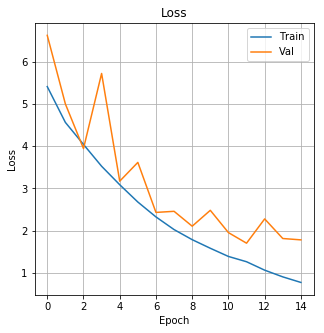

[5.40679392242, 4.5596849969228108, 4.0385965868631999, 3.5223032569885255, 3.0851254908243817, 2.6757282721201578, 2.3237145258585614, 2.0239918171564737, 1.7853538541793823, 1.5819609634081522, 1.3884473692576091, 1.2632822443644205, 1.0638857434590658, 0.90532179816563929, 0.77338855195045475]
[6.6191144104, 4.9968446578979488, 3.9410438385009767, 5.7172949600219729, 3.1694038734436036, 3.6134310607910156, 2.4302836456298826, 2.4560771675109865, 2.1042933731079101, 2.4797817115783691, 1.9523695945739745, 1.702160457611084, 2.2764737281799317, 1.8128202877044677, 1.780592399597168]


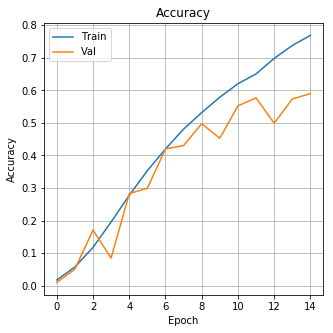

[0.0174166666667, 0.057083333333333333, 0.11733333333333333, 0.19545833333333335, 0.27737499999999998, 0.35308333333333336, 0.41979166666666667, 0.48083333333333333, 0.53170833333333334, 0.57887500000000003, 0.62033333333333329, 0.65045833333333336, 0.69804166666666667, 0.73779166666666662, 0.7689583333333333]
[0.00975, 0.050500000000000003, 0.17075000000000001, 0.084500000000000006, 0.28249999999999997, 0.29925000000000002, 0.41999999999999998, 0.43025000000000002, 0.4975, 0.45274999999999999, 0.55249999999999999, 0.57674999999999998, 0.499, 0.57325000000000004, 0.58999999999999997]


In [15]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.grid(True)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(train_losses)
print(val_losses)

plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.grid(True)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(train_acc)
print(val_acc)